In [1]:
import numpy as np
import pandas as pd
from glob import glob
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
# from pandarallel import pandarallel
import matplotlib.dates as mdates
import os
import time
# pandarallel.initialize()
import datetime

In [ ]:
plt.style.use('/home/luuk/Documents/MNRAS_stylesheet')

In [77]:
#######################################
###                                 ###
###   STEP 1: Read and clean data   ###
###                                 ###
#######################################

class datacleaner():
    def __init__(self):
        tstart=time.time()
        # Get list of all files
        flist = glob('./ASML/*csv')
        # Parallel read the files
        dfs= Parallel(n_jobs=8)(delayed(pd.read_csv)(i) for i in flist)
        print("Lengths",[len(w) for w in dfs])
        total_length1 = np.sum([len(w) for w in dfs])
        print(np.round(time.time()-tstart,2),"Read data")
        # Select only exchange "Q"
        dfs= Parallel(n_jobs=8)(delayed(self.select_exchange)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Selected on exchange")
        total_length2 = np.sum([len(w) for w in dfs])
        # Drop corrected
        dfs= Parallel(n_jobs=8)(delayed(self.drop_corr)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Dropped corrected")
        total_length3 = np.sum([len(w) for w in dfs])
        # Aggregate to second level
        dfs= Parallel(n_jobs=8)(delayed(self.resample)(i) for i in dfs)
        
        # Concatenate them vertically
        self.df = pd.concat(dfs)        
        # Sort them
        self.sort()
        # Get hourly dataframe        
        self.get_hourly()
        # Write to files
        self.write()
        #print(np.round(time.time()-tstart,2), "Done")
        #print(total_length1, total_length2, total_length3, 
        #      total_length4, total_length5, total_length6)
        
    def resample(self,df):
        df = df.reset_index()
        df['DATETIME'] = df['DATE'].astype(str) + ' ' + df['TIME_M']
        df['DATETIME'] = pd.to_datetime(df['DATETIME'])
        df = df.set_index('DATETIME')[['SIZE','PRICE']]
        
        #sizes  = df.resample('1S')[['SIZE']].sum()
        #prices = df.resample('1S')[['PRICE']].median()
        #df = sizes.join(prices)
        return df#.dropna()
        
    def select_exchange(self,df):
        return df[df.EX=='Q']
        
    def neg_outlier(self,df):
        # rolling window to remove outliers at 60std
        prices = df.PRICE
        r = prices.rolling(window=4000)  # Create a rolling object 
        mps = r.mean() - 60. * r.std()  # Combine a mean and stdev on that object
        outliers = prices[prices < mps].index
        df = df.drop(outliers)
        return df
        
    def drop_corr(self,df):
        # Drop all items that are corrected (see Barndorff-Nielsen)
        df = df[df.TR_CORR==0]
        return df
        
        
        
    def sort(self):
        self.df = self.df.sort_index()
        
    def get_hourly(self):
        # Aggregate to hourly dateframe, just for visualization
        self.hourly=self.df.reset_index().resample('H', on='DATETIME').median()
        
    def write(self):
        # Write to pickle files
        self.df.to_pickle('ASML_2015_2020.pickle')
        self.hourly.to_pickle('ASML_hourly.pickle')
    
    def get_df(self):
        return self.df
        
reader = datacleaner()
df = reader.get_df()
df

Lengths [1990692, 2242963, 1661203, 1496349, 2023934, 3561767]
6.44 Read data
14.13 Selected on exchange
17.32 Dropped corrected


,SIZE,PRICE
DATETIME,,
2015-01-02 09:30:00.313000000,2406,107.67
2015-01-02 09:30:00.313000000,2406,107.67
2015-01-02 09:30:16.990000000,400,107.71
2015-01-02 09:30:16.990000000,2,107.71
2015-01-02 09:30:16.990000000,298,107.71
...,...,...
2020-12-31 15:59:59.902544214,100,487.82
2020-12-31 15:59:59.902610513,4,487.82
2020-12-31 15:59:59.905837219,96,487.82


In [3]:
# Read in pickle file
df = pd.read_pickle('ASML_2015_2020.pickle')

In [4]:
df_highres_covid = df.loc['2020-03-16']

In [ ]:
# Read in splitted files
df = pd.concat([pd.read_pickle(w) for w in ['df.part1.pickle','df.part2.pickle']])

In [5]:
days = df.resample('1D').median()
days = days.dropna().index
days = pd.Series(days).apply(lambda x: x.strftime('%Y-%m-%d')).values[:500]
daily_counts = df[['PRICE']].resample('1D').count()
# Write to hdf5 file to parallel read them
os.system('rm -rf ./data.h5')
df.to_hdf('data.h5', key='df', mode='w')
daily_counts.to_hdf('days.h5', key='df', mode='w')

In [6]:
df['LOGPRICE'] = np.log(df.PRICE)
df['DELTALOG'] = df['LOGPRICE'].diff()*100

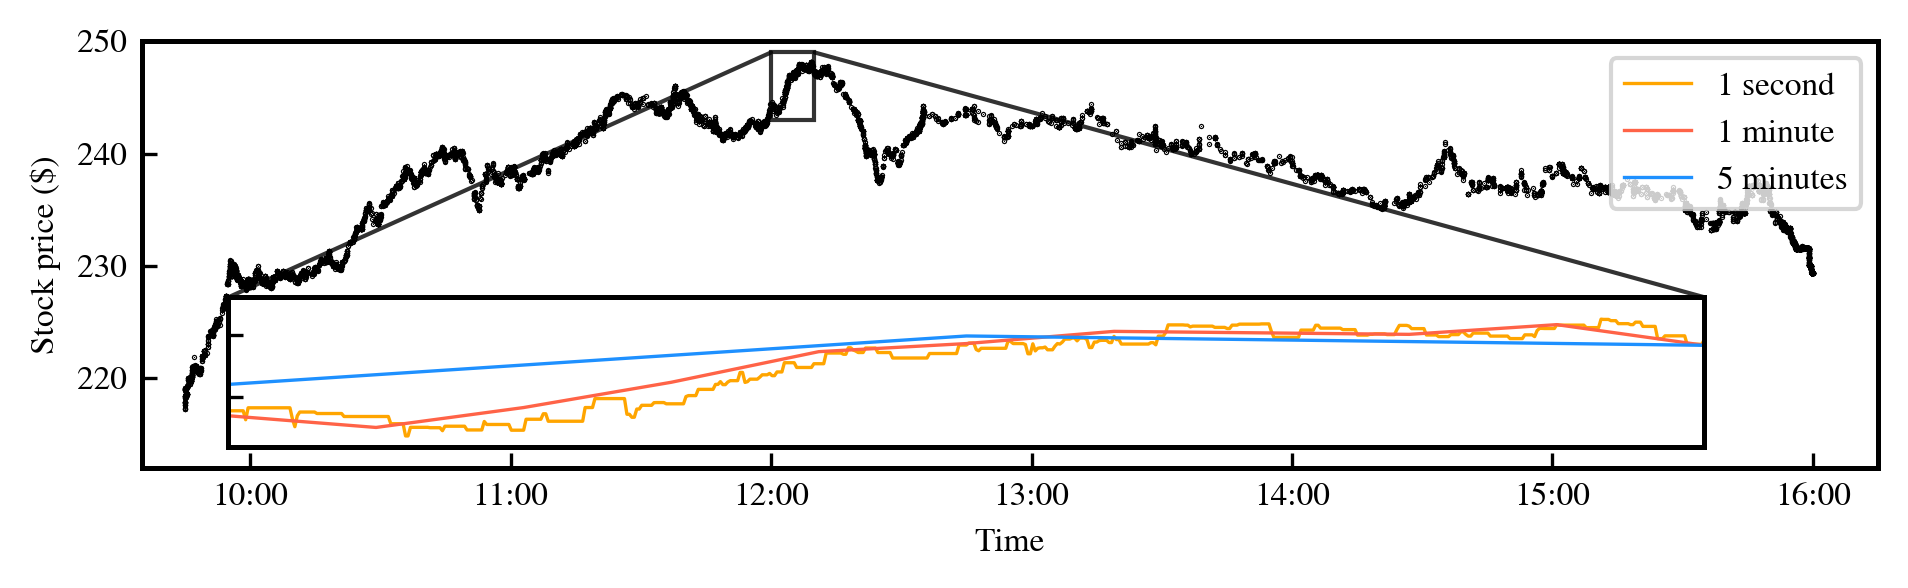

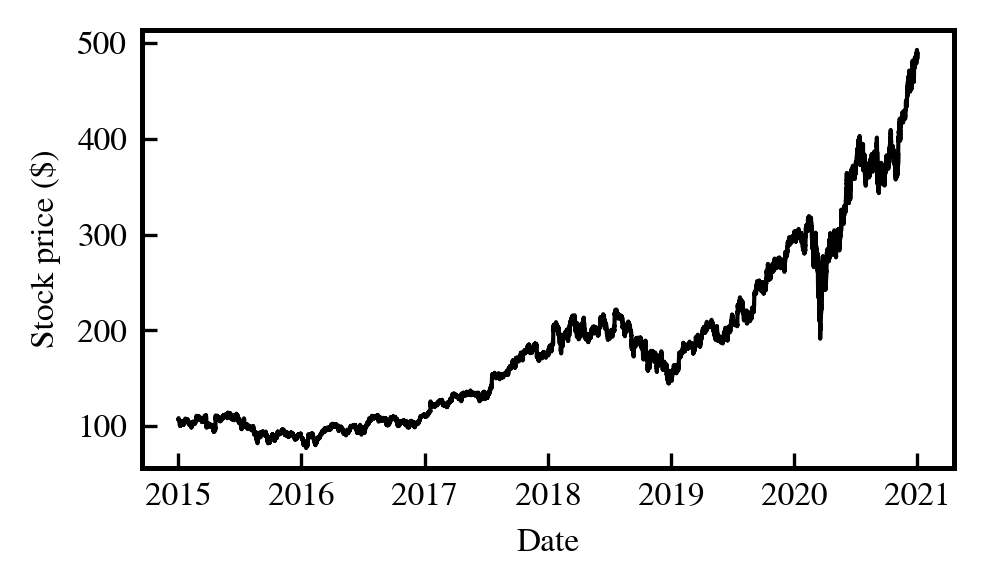

In [7]:
def plot_one_day():
    fig,ax = plt.subplots(figsize=(6.4,2))
    ax.scatter(df_highres_covid.index, df_highres_covid.PRICE,s=0.08,color='black')
    
    xformatter = mdates.DateFormatter('%H:%M')
    plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
    plt.xlabel('Time')
    #plt.yticks(np.arange(135,149,3))
    plt.ylim(212,250)
    plt.ylabel('Stock price ($)')
    
    plt.xlim(datetime.datetime(2020,3,16,9,35,0),datetime.datetime(2020,3,16,16,15,0))
    axins = ax.inset_axes([0.05, 0.05, 0.85, 0.35])
    corona_peak1_min = df_highres_covid.resample('1T')[['PRICE']].median().fillna(method='ffill')
    corona_peak5_min = df_highres_covid.resample('5T')[['PRICE']].median().fillna(method='ffill')
    corona_peak1_sec = df_highres_covid.resample('1s')[['PRICE']].median().fillna(method='ffill')
    
    axins.plot(corona_peak1_sec.index, corona_peak1_sec,lw=0.8,color='orange',label = '1 second')
    #axins.plot(corona_peak1_sec.index, corona_peak1_sec,lw=0.8,color='orange',label='1 second')
    axins.plot(corona_peak1_min.index, corona_peak1_min,lw=0.8,color='tomato',label='1 minute')
    axins.plot(corona_peak5_min.index, corona_peak5_min,lw=0.8,color='dodgerblue',label='5 minutes')
    
    
    
    # sub region of the original image
    x1 = datetime.datetime(2020,3,16,12,0,0)
    x2 = datetime.datetime(2020,3,16,12,10,0)
    y1, y2 = 243,249#144.7,146.8
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticks([])
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    #axins.tick_params(axis="y",direction='in',pad=-35)

    #axins.set_yticks([0.5,0.55])
    axins.set_yticklabels('')
    ax.indicate_inset_zoom(axins,lw=1,alpha=0.8,edgecolor='black',label='')
    handles, labels = axins.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper right',frameon=1)
    plt.tight_layout()
    plt.savefig('ASML_intraday.pdf',bbox_inches='tight')
    
    plt.show()
def plot_all():
    plt.figure(figsize=(3.321,2))
    plt.plot(df.index, df.PRICE,color='black',lw=1)
    
    plt.xlabel('Date')
    plt.ylabel('Stock price ($)')
    plt.tight_layout()
    plt.savefig('ASML_6years.pdf',bbox_inches='tight')
    plt.show()
plot_one_day()
plot_all()

In [ ]:
class realized_kernel():
    def __init__(self):
        """Initialize, call some functions"""
        self.make_time_index()
        return

    def make_time_index(self):
        """We want the data to be restructured onto a regular 1 sec grid 
           to obtain the sparse estimates. Therefore we built a list of 1sec
           times"""
        # Define time arr for every second
        times = []
        for hours in range(9,16):
            for minutes in range(0,60):
                for seconds in np.arange(0,60,1):
                    h = str(hours) if hours>=10 else '0'+str(hours)
                    m = str(minutes) if minutes>=10 else '0'+str(minutes)
                    s = str(seconds) if seconds>=10 else '0'+str(seconds)
                    times.append(h+':'+m+':'+s)
        #times = times[60:]
        self.times = times[1800:]
        
    def make_regular_df(self,onedaydf):
        """Make 1 sec regular dataframe from irregular one day dataframe of prices.
           Note, irregular_day_df should be a 1-day only dataframe with prices
           (no sizes here). If there is no trade, we take the previous time"""
        # Extract times from datetimes
        onedaydf['logprice'] = np.log(onedaydf.PRICE)
        # Get deltalog and deltalog^2 prices
        onedaydf['deltalog'] = onedaydf.logprice.diff()*100
        onedaydf['deltalog2'] = (onedaydf['deltalog'])**2
        
        regular_df = onedaydf.resample('1S')[['PRICE']].median().fillna(method='ffill')
        regular_df['logprice'] = np.log(regular_df.PRICE)
        # Get deltalog and deltalog^2 prices
        regular_df['deltalog'] = regular_df.logprice.diff()*100
        regular_df['deltalog2'] = (regular_df['deltalog'])**2
        
        return regular_df, onedaydf
        
    
    def get_sparse_IV(self,df):
        """Make 1 minute interpolated dataframe"""
        IV_sparse= []
        for i in range(0,22200):
            ds = datetime.timedelta(seconds=i)
            sec_df = df.loc[df.index[0]+ds:df.index[0]+datetime.timedelta(minutes=20)+ds]
            IV_sparse.append(sec_df['deltalog2'].sum()*6.5*3)
        IV_sparse =np.median(IV_sparse)
        return IV_sparse
        
    
    def get_RV_sparse(self,input_logprices):
        """Obtain estimate for RVsparse using the 1-sec interpolated logprices"""
        offsets = np.arange(1200)
        RVs =  np.zeros(1200) # 20min sets
        for offset in offsets:
            # built array (ie 0,1200,2400, etc)
            tochoose = np.arange(0+offset,len(input_logprices),1200)
            # select each 1200th element (plus offset)
            logprices = input_logprices.iloc[tochoose].values.flatten()
            diffs = np.diff(logprices)*100
            RV = np.sum(diffs**2)
            RVs[offset] = RV
        return np.mean(RVs)
    
    
    def RV_dense(self,input_logprices):
        """Get estimate for the dense RV using all irregular spaced returns"""
        q = 25
        offsets = np.arange(q)
        RVs = np.zeros(q)
        Ns  = np.zeros(q)
        for offset in offsets:
            tochoose = np.arange(0+offset,len(input_logprices),q)
            logprices = input_logprices.iloc[tochoose].values.flatten()
            diffs = np.diff(logprices)*100
            RV = np.sum(diffs**2)
            RVs[offset] = RV
            Ns[offset]  = (diffs>0).sum()
        return RVs,Ns
    
    def get_omega(self,df_irregular):
        """Get estimate for omega^2 hat"""
        # collect RVdense estimates
        RVdenses,Ns = self.RV_dense(df_irregular[['logprice']])
        omega2hat_i = RVdenses / (2*Ns)
        omega2hat = np.mean(omega2hat_i)
        return omega2hat
    
    
    def get_optimal_bandwidth(self,regular_df,irregular_df):
        # get estimate for sparse RV
        rvsparse = self.get_RV_sparse(regular_df[['logprice']])
        # Get omega
        omega2hat = self.get_omega(irregular_df)
        xi2 = omega2hat / rvsparse
        xi = np.sqrt(xi2)
        H =  int(3.5134*len(irregular_df)**(3/5)*xi**(4/5))
        return H
    
    
    def Parzen(self,x):
        """Return Parzen kernel for x"""
        if 0<=np.abs(x)<=1/2:
            return 1-6*np.abs(x)**2+6*np.abs(x)**3
        elif 1/2<=np.abs(x)<=1:
            return 2*(1-np.abs(x))**3
        elif np.abs(x)>1:
            return 0
        
    def obtain_K(self,H,irregular_df):
        # make array to loop from -H to H
        h_arr = np.arange(-H,H+1,1,dtype=int)
        irregular_df['deltalog'] = np.log(irregular_df.PRICE).diff().values*100
        # make flat numpy array from the raw return data (approx second)
        x = irregular_df.deltalog.dropna().values.flatten()
        #x = x[np.abs(x)>0]

        K_X = 0
        parzen_values=[]
        # loop 1 over the lags
        gamma1 = 0
        for h in h_arr:
            j_arr = np.arange(np.abs(h)+1,len(x)+1,dtype=int)
            gamma_h = 0
            # loop two for the autocovariances
            for j in j_arr:
                gamma_h += x[j-1]*x[j-np.abs(h)-1]
            K_X += gamma_h*self.Parzen(h/(H+1))
            if h==1:
                gamma1 = gamma_h
        return K_X,gamma1
    
    def worker(self,day,H=None,get_H=False,ret_gamma1=False):
        """worker to loop over days"""
        try:
            daily_counts = pd.read_hdf('./days.h5')
            counts = daily_counts.loc[day].iloc[0]
            # to be faster: find where we are approximately
            iloc0 = max(int(daily_counts.loc[:day].sum().iloc[0]-counts)-10000,0)
            hdf_df = pd.read_hdf('./data.h5')
            
            oneday = hdf_df.iloc[iloc0:counts+iloc0+10000].loc[day]
            # get regular and irregular dfs
            regular_df, irregular_df = self.make_regular_df(oneday)
            # make sparse (1min) df
            #prse_oneday = self.make_sparse_df(oneday)
            #print(prse_oneday)
            # get RVsparse
            RVsparse = self.get_RV_sparse(regular_df[['logprice']])
            
            # get optimal bandwidth
            Hopt = self.get_optimal_bandwidth(regular_df, irregular_df)
            # get realized kernel estimate 
            if not H:
                H = Hopt
                print('Hopt',Hopt)
            else:
                H = H
            RK_est,gamma1 = self.obtain_K(H,irregular_df)
            print(day,'success')
            if ret_gamma1:
                return RK_est,gamma1
            if get_H:
                return RK_est,H
            else:
                return RK_est
        except:
            print(day,'failed')
            return np.nan
    def iterate_over_days(self):
        # Get unique days in dataset
        daily_counts = pd.read_hdf('./days.h5')
        df = pd.read_hdf('data.h5')
        days = daily_counts.index[(daily_counts>0).values.flatten()]
        days = [w.strftime('%Y-%m-%d') for w in days]
        # iterate over days
        RK_estimates = Parallel(n_jobs=23)(delayed(self.worker)(i,get_H=False,ret_gamma1=True) for i in days)
        RKs = np.array([w[0] for w in RK_estimates])
        gamma_1s = np.array([w[1] for w in RK_estimates])
        print(gamma_1s)
        #np.array([self.worker(day) for day in days[:N]])#
        self.RKvalues = pd.DataFrame({'Day':days,'RealizedKernel':RKs})
        return self.RKvalues,gamma_1s

    def signature_plot(self,day):
        Hs = np.hstack((np.logspace(0.1,2.5,80,dtype=int),[None]))
        
        #K_Hs = [self.worker(day,H,False,True) for H in Hs]
        K_Hs = Parallel(n_jobs=23)(delayed(self.worker)(day,H,True,False) for H in Hs)
        Ks = np.array([w[0] for w in K_Hs])
        gamma1s = np.array([w[1] for w in K_Hs])

        plt.figure()
        plt.ylabel('IV estimate')

        plt.plot(Hs,Ks,color='dodgerblue',label='Realized Kernel',lw=1,zorder=1)
        #plt.scatter(H_opt,obtain_K(H_opt),color='red',s=2)
        
        
        daily_counts = pd.read_hdf('./days.h5')
        counts = daily_counts.loc[day].iloc[0]
        # to be faster: find where we are approximately
        iloc0 = max(int(daily_counts.loc[:day].sum().iloc[0]-counts)-1000,0)
        hdf_df = pd.read_hdf('./data.h5')
        oneday = hdf_df.iloc[iloc0:counts+iloc0+1000].loc[day]
        
        
        #regular_df, irregular_df = self.make_regular_df(oneday)
        #sparse_IV = self.get_sparse_IV(regular_df)
        sparse_IV = ((np.log(df.loc[day].resample('1T')[['PRICE']].median()).diff()*100)**2).sum().iloc[0]
        plt.axhline(sparse_IV,color='tomato',lw=0.7,label='Sparse volatility')
        plt.xlabel('Bandwidth')
        #plt.ylim(13,26)
        
        plt.scatter(K_Hs[-1][1],K_Hs[-1][0],label=r'$H^*$',color='orange',s=8,zorder=2)
        plt.legend(frameon=1,loc='upper right')
        plt.tight_layout()
        plt.savefig('vola_vs_bandwidth.pdf')
        plt.show()

    def plot_RKvol(self):
        RK_values = self.RKvalues
        ### plot figure
        RK_values.index = pd.to_datetime(RK_values.Day)
        df_1min = df[['PRICE']].resample('1T').median()
        df_1min['logprice'] = np.log(df_1min.PRICE)
        df_1min['deltalog'] = df_1min.logprice.diff()*100
        df_1min['deltalog2'] = (df_1min.logprice.diff()*100)**2
        sparse_volas = np.sqrt(252*df_1min.deltalog2.resample('1D').sum())
        plt.plot(RK_values.index,RK_values.RealizedKernel,lw=1,label='RKVOL')
        plt.plot(sparse_volas[sparse_volas>0],lw=1,label='RVOL')
        plt.legend(frameon=1)
        plt.ylabel('Annualized volatility [%]')


RK = realized_kernel()
RK.signature_plot('2017-05-26')

In [15]:
RK_values,gamma_1s = RK.iterate_over_days()

[ 0.02059994 -0.02654572  0.03806595 ... -0.22748042 -0.09813863
 -0.15306988]


In [ ]:
RK_values = RK_values.set_index('Day')

In [237]:
RK_values.index = pd.to_datetime(RK_values.index)

In [11]:
def RV(samplefreq):
    # Resample to given frequency
    resampled = df.resample(samplefreq).PRICE.median().dropna()
    resampled['LOGPRICE'] = np.log(resampled)
    resampled['DELTALOG'] = resampled['LOGPRICE'].diff()*100
    resampled['DELTALOG2'] = resampled['DELTALOG']**2
    
    # Obtain RV
    RV = resampled['DELTALOG2'].resample('1D').sum()
    # Obtain RVOL
    RVOL = np.sqrt(RV*252)
    RVOL = RVOL[RVOL>0]
    return RVOL

In [16]:
RVOL_30s = RV('30S')
RVOL_5min =  RV('5T')
RVOL_60min =  RV('60T')

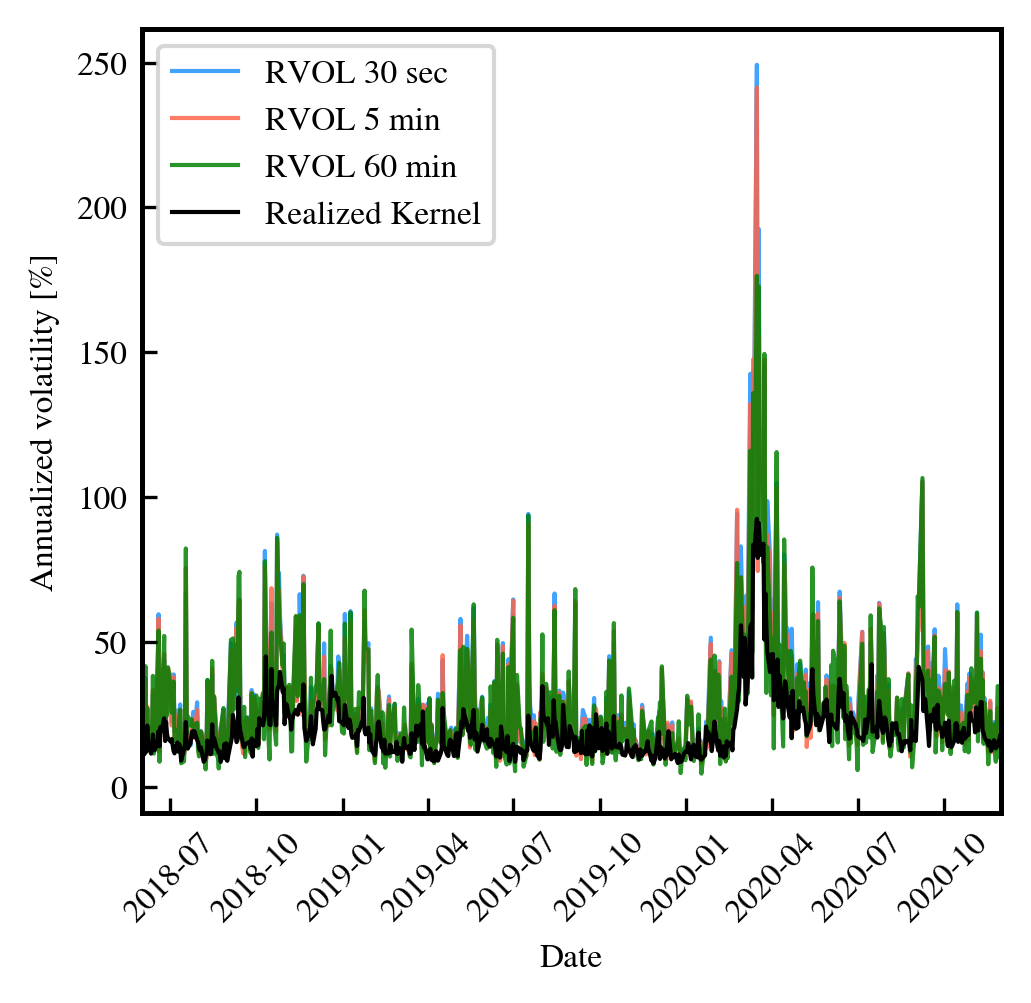

In [19]:
def compare_RV_RK():
    #RVOL_1s = RV('1S')
    RK = np.sqrt(252*RK_values.RealizedKernel)
    RK_days = pd.to_datetime(RK_values.Day)
    fig,ax = plt.subplots()
    #plt.plot(RVOL_1s.index,RVOL_1s.values,lw=0.6,label='RVOL 1 sec')
    plt.plot(RVOL_30s.index,RVOL_30s.values,lw=1,label='RVOL 30 sec',color='dodgerblue',alpha=0.84)
    plt.plot(RVOL_5min.index,RVOL_5min.values,lw=1,label='RVOL 5 min',color='tomato',alpha=0.84)
    plt.plot(RVOL_60min.index,RVOL_60min.values,lw=1,label='RVOL 60 min',color='green',alpha=0.84)
    plt.plot(RK_days, RK,lw=1,label='Realized Kernel',color='black')
    plt.legend(frameon=1,loc='upper left')
    plt.tight_layout()
    plt.xlim([datetime.date(2018, 6, 1), datetime.date(2020, 12, 1)])
    plt.ylabel('Annualized volatility [%]')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.savefig('RVOL_vs_RK.pdf',bbox_inches='tight')
    plt.show()
compare_RV_RK()

<ipython-input-251-cba543c612a1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LOGPRICE'] = np.log(df.PRICE)
<ipython-input-251-cba543c612a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DELTALOG'] = (df.LOGPRICE.diff()*100)
/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

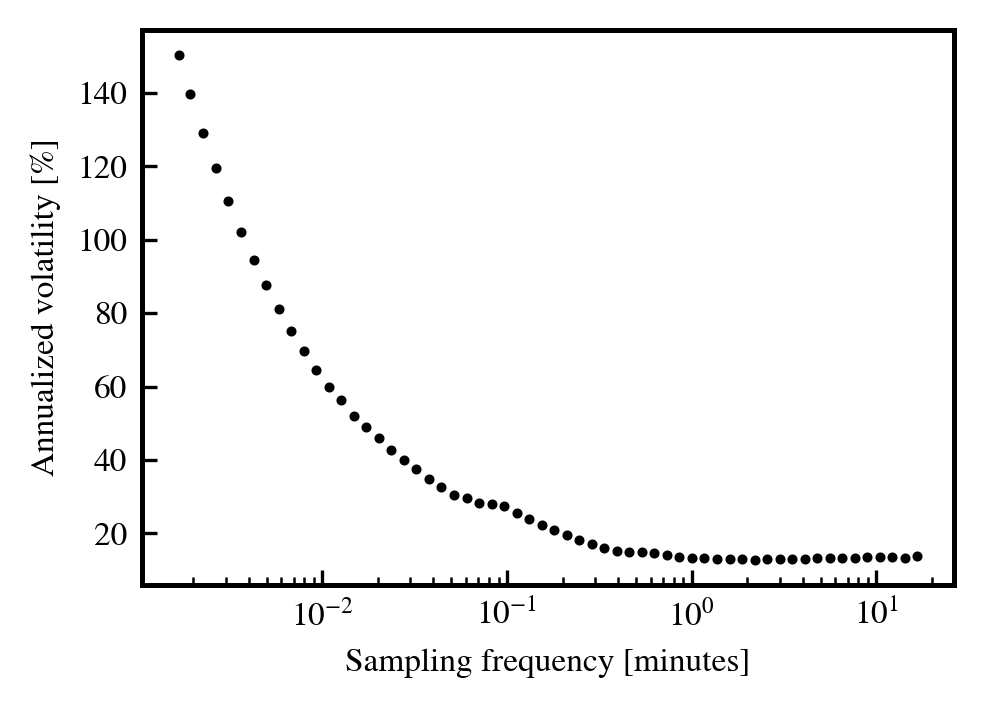

In [251]:
class signature_plot():
    def __init__(self):
        # Get df with deltalog returns
        self.length = 100000
        self.__prep_df__(df[:self.length])
        self.__obtain_RVs__()
        return
    
    def __prep_df__(self,df):
        df['LOGPRICE'] = np.log(df.PRICE)
        # Convert to returns
        df['DELTALOG'] = (df.LOGPRICE.diff()*100)
        # Only intraday, no interday returns since these screw up the results
        newday = pd.Series(df.index).diff()[pd.Series(df.index).diff()>pd.Timedelta('1h')].index
        df.loc[df.iloc[newday].index,'DELTALOG']=np.nan
        self.df = df[['DELTALOG']]
        
    def __worker__(self,dT):
        RVs = (self.df[:self.length].DELTALOG**2).resample(str(dT)+'ms').sum()
        RVOL = np.sqrt(np.median(RVs[RVs>0]))
        RVOL = RVOL * np.sqrt(252) * np.sqrt(6.5*3600*1000/dT)
        return RVOL
    
    def __obtain_RVs__(self):
        N = 60
        dT_array = np.logspace(2,6,N,dtype=int)
        RVOLs = Parallel(n_jobs=20)(delayed(self.__worker__)(dT) for dT in dT_array)
        self.dT = dT_array
        self.RVOLs = RVOLs
        
    def __plot__(self):
        plt.figure(figsize=(3.321,2.4))
        plt.scatter(self.dT/60000, self.RVOLs,color='black',s=2)
        plt.semilogx()
        plt.xlabel('Sampling frequency [minutes]')
        plt.ylabel('Annualized volatility [%]')
        plt.tight_layout()
        plt.savefig('signature_plot.pdf',bbox_inches='tight')
        plt.show()
        
sigplotter = signature_plot()
sigplotter.__plot__()

In [20]:
closingprices = df[['PRICE']].groupby(df.index.date).apply(lambda x: x.iloc[[-1]])
closingprices.index = closingprices.index.droplevel(0)
daily_returns = np.log(closingprices).diff().iloc[1:]

mean: 0.10014494220969888 skew: -0.645342552220145 kurtosis: 7.872997901937509


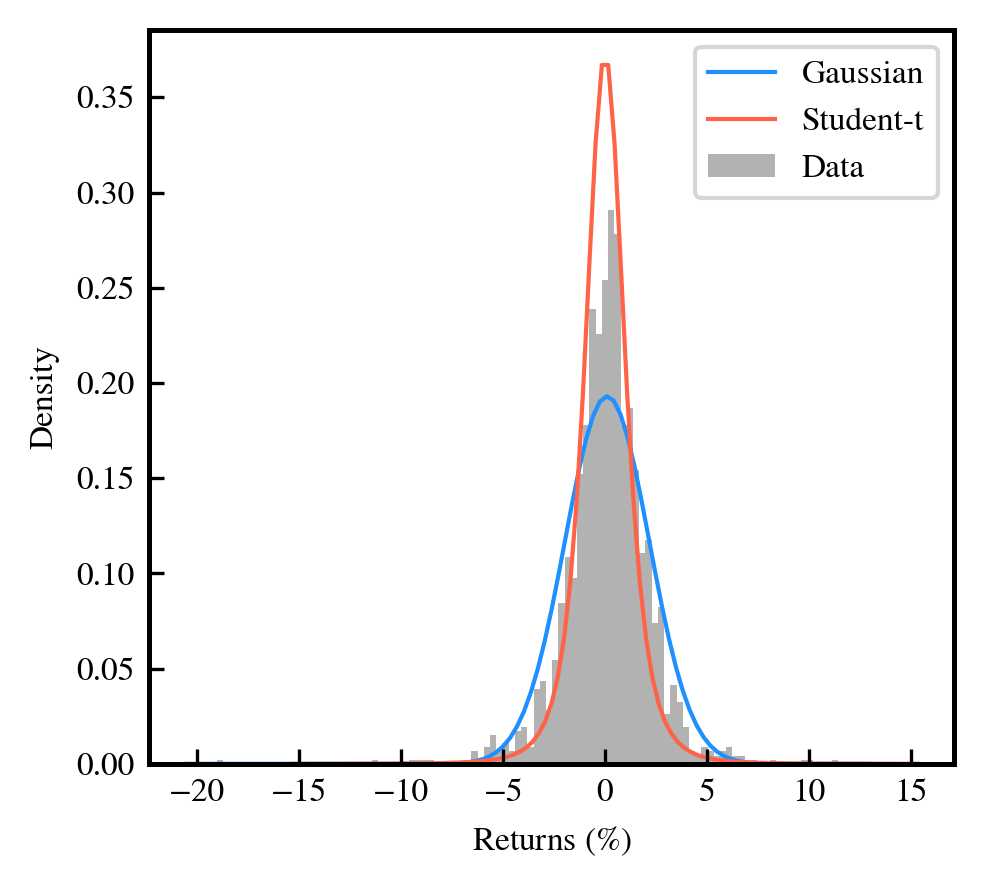

In [304]:
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import t

def return_dist(closingreturns):
    mu_data = np.mean(closingreturns)
    std_data = np.std(closingreturns)
    skew_data = stats.skew(closingreturns)
    kurt_data = stats.kurtosis(closingreturns)

    # Fit a normal distribution to the data
    mu, std = norm.fit(closingreturns)
    p = norm.pdf(closingreturns, mu, std)

    # Fit a t-distribution to the data
    df = t.fit(closingreturns)[0]
    mean, var, skew, kurt = t.stats(df, moments='mvsk')
    
    fig, ax = plt.subplots(1, 1)
    # Plot histogram
    plt.hist(closingreturns, bins=100, density=True, color='black', alpha=0.3, label='Data')

    # Plot the normal PDF
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=1, label='Gaussian', color='dodgerblue')

    # Plot the t PDF
    x = np.linspace(t.ppf(0.0001, df), t.ppf(0.9999, df), 100)
    plt.plot(x, t.pdf(x, df), alpha=1, label='Student-t', color='tomato', lw='1')

    plt.xlabel('Returns ($\%$)')
    plt.ylabel('Density')
    plt.legend(frameon=1)
    plt.tight_layout()
    plt.savefig('Return_distribution.pdf',bbox_inches='tight')
    print('mean:', mu_data, 'skew:', skew_data, 'kurtosis:', kurt_data)
    
returns_daily = daily_returns.values.flatten()*100
return_dist(returns_daily)

In [176]:
from scipy.optimize import minimize
class estimate_GARCH():
    def __init__(self,model,p,q):# or 'RealGARCH'
        self.options = {'eps':1e-09,
                      'disp': True,
                      'maxiter':2000}
        self.p,self.q = p,q
        self.model = model # 'RealGARCH'
        self.closingreturns = daily_returns.values.flatten()*100
        self.__RVOL__()
        # Call fit of GARCH
        self.fit_garch(self.closingreturns)
        return
    
    def __RVOL__(self):
        """Obtain realized volatilities from highfreq data"""
        # Convert to logprices
        df['LOGPRICE'] = np.log(df.PRICE)
        # Convert to returns
        df['DELTALOG'] = df.LOGPRICE.diff()*100
        # Only intraday, no interday returns since these screw up the results
        newday = pd.Series(df.index).diff()[pd.Series(df.index).diff()>pd.Timedelta('1h')].index
        df.loc[df.iloc[newday].index,'DELTALOG']=np.nan
        # Take sum of squared returns within one day and resample to annual volatility
        self.RVOL = np.sqrt((df[['DELTALOG']]**2).resample('1D').sum())
        self.RVOL = self.RVOL[self.RVOL>0]
        # Daily returns do not have first day and no weekends, so drop them
        self.RVOL = self.RVOL.dropna().values.flatten()[1:]
    
    def __llik_fun_GARCH__(self,params,estimate=True):
        x = self.closingreturns
        n = len(x)
        # Convert parameters back from their log normalization
        omega = np.exp(params[0])
        
        alphas = np.zeros(self.q)
        betas  = np.zeros(self.p)
        
        for i in range(0,self.q):
            alphas[i] = np.exp(params[i+1])/(1+np.exp(params[i+1]))
        for i in range(0,self.p):
            betas[i] = np.exp(params[i+self.q+1])/(1+np.exp(params[i+self.q+1]))
        
        # Iterate through sigma2 using the GARCH updating rules
        sigma2 = np.zeros(n)
        # fill first values with sample variance
        for i in range(0,max(self.p,self.q)+1):
            sigma2[i] = np.var(x)
        # Iterate through times
        for t in range(max(self.p,self.q),n):
            alpha_part = 0
            beta_part  = 0
            # Obtain beta part (lagged sigma2)
            for i in range(0,self.p):
                beta = betas[i]
                beta_part = beta_part+beta*sigma2[t-i-1]
            # Obtain alpha part (lagged returns)
            for i in range(0,self.q):
                alpha = alphas[i]
                
                if self.model == 'GARCH':
                    alpha_part = alpha_part+alpha*x[t-i-1]**2
                if self.model == 'RealGARCH':
                    alpha_part = alpha_part+alpha*self.RVOL[t-i-1]**2
            # Combine in sigma2[t]
            sigma2[t] = omega + alpha_part + beta_part
        
        # Derive likelihood
        if estimate:
            L = -0.5*np.log(2*np.pi) - 0.5*np.log(sigma2) - 0.5*x**2/sigma2

            llik = np.mean(L)

            return -1*llik
        else:
            return sigma2
    
    
    def fit_garch(self,x):
        # Initialize values
        b = np.ones(self.p)*(0.4/self.p)  # initial value for beta
        a = np.ones(self.q)*(0.1/self.q) # initial value for alpha
        omega = np.nanvar(self.closingreturns)*(1-np.sum(a)-np.sum(b)) # initial value for omega
        
        par_ini = np.array([omega])#np.array([np.log(omega)])
        
        alphas = np.zeros(self.q)
        betas  = np.zeros(self.p)
        
        for i in range(0,self.q):
            alphas[i] = np.log(a[i]/(1-a[i]))
        for i in range(0,self.p):
            betas[i] = np.log(b[i]/(1-b[i]))
        
        par_ini = np.hstack((par_ini,alphas, betas))
        
        est = minimize(self.__llik_fun_GARCH__, x0=par_ini,
                       options = self.options,
                       method = 'SLSQP',
                       #bounds = ((0.0001, 100), (0, 10), (0,1))
                      )
        llikhood = -est.fun
        self.AIC = 2*(len(par_ini))-2*llikhood
        self.BIC = (len(par_ini)) * np.log(len(self.closingreturns)) - 2*llikhood
        self.llik_opt = llikhood
        
        self.estimates = est.x
        omega_hat = np.exp(self.estimates[0])
        
        betas = np.array([np.exp(w)/(1+np.exp(w)) for w in self.estimates[1:self.p+1]])
        alphas = np.array([np.exp(w)/(1+np.exp(w)) for w in self.estimates[1+self.p:]])
        
        self.thetahat = np.hstack((omega_hat,alphas,betas))
        
        
    def return_vola(self):
        sigma2 = self.__llik_fun_GARCH__(self.estimates,estimate=False)
        return daily_returns.index,sigma2#np.sqrt(sigma2)*np.sqrt(252)
    
    def return_llik_AIC_BIC(self):
        return self.AIC,self.BIC,self.llik_opt
    
    def predict_one_step(self):
        # The input to our prediction is the returns until time t
        # We thus estimate our GARCH model with this data
        # We want to estimate the volatility at time t+1
        # We thus predict the volatility at the next timestep using the estimated GARCH
        training_data = pd.concat([daily_returns.loc[year] for year in ['2015','2016','2017','2018']])
        
        # Fit the GARCH model using the first four years of data
        self.closingreturns = training_data.values.flatten()*100
        
        if self.model=='RealGARCH':
            # If we want the RealGARCH model, obtain realized volatilities
            self.__RVOL__()
        # Call fit of GARCH
        self.fit_garch(self.closingreturns)
        
        # Now we have fitted the GARCH model. We try to predict 
        testingdata = pd.concat([daily_returns.loc[year] for year in ['2019','2020']])
        self.closingreturns = testingdata.values.flatten()*100
        sigma2 = self.__llik_fun_GARCH__(self.estimates,estimate=False)
        return testingdata.index,sigma2


GARCH33 = estimate_GARCH(model='GARCH',p=3,q=3)
GARCH33_time, GARCH33_vola = GARCH.return_vola()
#GARCH = estimate_GARCH(model='RealGARCH',p=2,q=2)
#RealGARCH_time, RealGARCH_vola = GARCH.return_vola()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.037889505243519
            Iterations: 95
            Function evaluations: 771
            Gradient evaluations: 95


In [315]:
def OLS(sigmas_1,sigmas_2):
    #plt.scatter(sigmas_1,sigmas_2,s=1)
    yfit = np.polyfit(sigmas_1,sigmas_2,deg=1)
    slope, const = yfit
    return slope, const



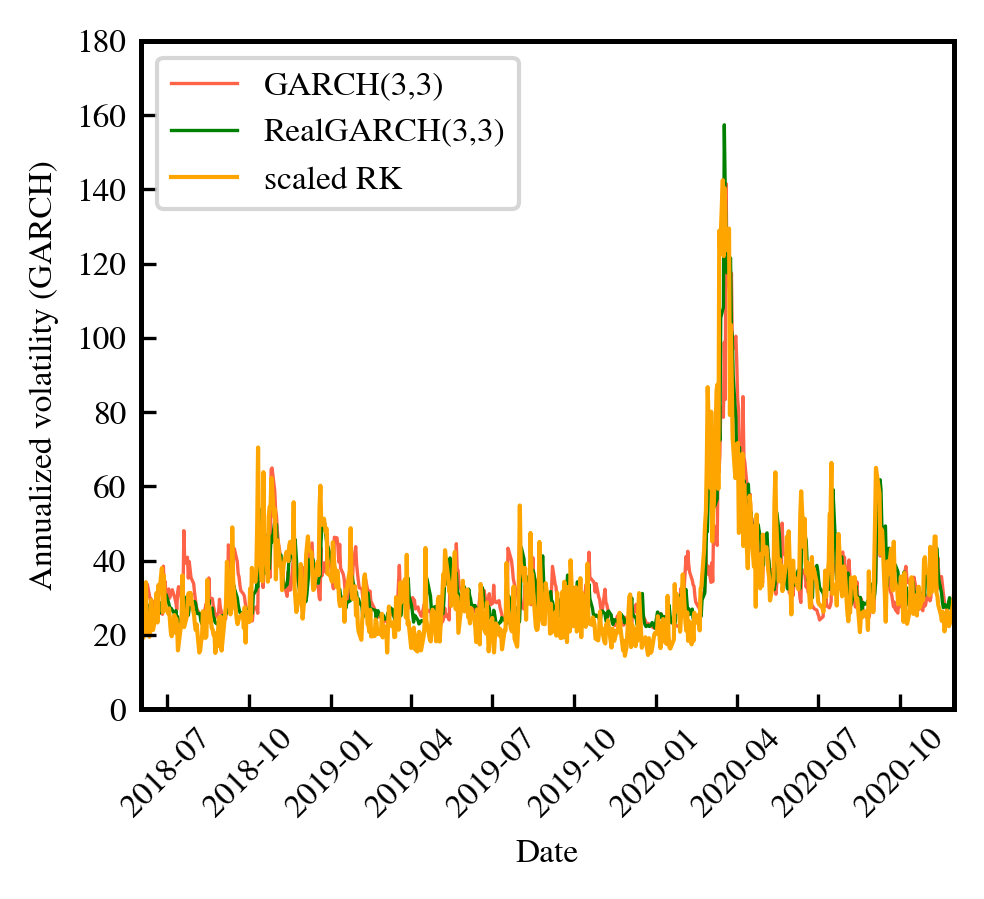

In [136]:
def plot_GARCHestimates():
    
    fig,ax=plt.subplots()
    plt.plot(GARCH_time, GARCH_vola,label='GARCH(3,3)',lw=0.8,color='tomato')
    #plt.plot(RealGARCH_time,GARCH.RVOL*np.sqrt(252),lw=0.8,label='RealVol',color='orange')
    plt.plot(RealGARCH_time, RealGARCH_vola,label='RealGARCH(3,3)',lw=0.8,color='green')
    plt.xlim([datetime.date(2018, 6, 1), datetime.date(2020, 12, 1)])
    #RKvolas = np.sqrt(252*RK_values.RealizedKernel[1:])
    #plt.plot(RealGARCH_time,RKvolas,lw=0.2,label='RKVOL',color='dodgerblue')
    plt.plot(RK_to_GARCH33,color='orange',label='scaled RK',lw=1)
    RKvolas_new = OLS(GARCH_vola,RKvolas)
    #plt.plot(RealGARCH_time,RKvolas_new,lw=0.8,label='RKVOL',color='red')
    
    #plt.plot(RVOL_5min.index,RVOL_5min,lw=0.2,label='RVOL')

    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Annualized volatility (GARCH)')
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.ylim(0,180)
    plt.savefig('Garch_RealGARCH_RVOL.pdf',bbox_inches='tight')
    plt.show()
plot_GARCHestimates()

In [316]:
from scipy.optimize import minimize
from scipy.special import gamma, factorial, polygamma
class estimate_GAS():
    def __init__(self,model,p,q):# or 'RealGARCH'
        self.options = {'eps':1e-09,
                      'disp': True,
                      'maxiter':200}
        self.p, self.q = p, q
        #beta = nu#self.p + self.q + 1 # dof for t-distribution
        self.model = model # 'RealGARCH'
        self.closingreturns = daily_returns.values.flatten()*100
        if self.model=='RealGARCH':
            # If we want the RealGARCH model, obtain realized volatilities
            self.__RVOL__()
        # Call fit of GARCH
        self.fit_gas(self.closingreturns)
        return
    
    
    def nabla(self,lagged_obs,lagged_latent,beta,xhi,p,q):
        ht = np.exp(lagged_latent)
        # Normal distribution
        if self.model == 'GARCH':
            return -1/2 + lagged_obs**2/(2*ht)
        # t-distribution density
        if self.model == 't-GAS':
            c=-0.5
            a=(beta+1)*lagged_obs**2
            b=2*(lagged_obs**2+(beta-2)*ht)
            return c+a/b
        if self.model == 'GED':
            c=-0.5
            lambda_ = np.sqrt(gamma(1/beta)/(2**(2/beta)*gamma(3/beta)))
            a=lagged_obs**2*beta * np.abs(lagged_obs/(lambda_*np.sqrt(ht)))**(beta-2)
            b = 4*lambda_**2*ht
            return c+a/b
        if self.model == 'skewed_t':
            c=-0.5
            # Restriction: Beta > 2
            m = (gamma((beta-1)/2))/(gamma(beta/2))*(np.sqrt((beta-2)/np.pi))*(xhi-(1/xhi))
            s = np.sqrt(xhi**2+(1/xhi**2)-1-m**2)
            rho = s*((lagged_obs)/np.sqrt(ht)) + m
            if rho => 0:
                  It = 1
            elif rho < 0:
                  It = -1
            a = lagged_obs*s*(beta+1)*rho*xhi**(-2*It)
            b = 2*(beta-2)*np.sqrt(ht)*(1+(rho**2*(xhi**(-2*It)))/(beta-2))
            return c+a/b        
        if  self.model == 'EGB2':
            c = -0.5
            delta = special.polygamma(0,p) - special.polygamma(0,q)
            omega = special.polygamma(1,p) - special.polygamma(1,q)
            upsilon = np.exp(delta+np.sqrt(omega)*lagged_obs/np.sqrt(ht))
            d = (np.sqrt(omega)*p*lagged_obs)/(2*np.sqrt(ht))
            a = np.sqrt(omega) *lagged_obs*(p+q)*upsilon
            b = 2*np.sqrt(ht)*(upsilon+1)
            return (a/b)-d+c
        
    def __llik_fun_GAS__(self,params,estimate=True):
        x = self.closingreturns
        n = len(x)
        # Convert parameters back from their log normalization
        mu = params[0]
        phis = params[1:self.p+1]
        alphas = params[1+self.p:-1]
        beta = params[-1]
        # Iterate through sigma2 using the GARCH updating rules
        ft = np.zeros(n)
        # fill first values with sample variance
        for i in range(0,max(self.p,self.q)+1):
            ft[i] = np.log(np.var(x))
        # Iterate through times
        for t in range(max(self.p,self.q),n):
            phi_part = 0
            alpha_part  = 0
            # Obtain beta part (lagged sigma2)
            for i in range(0,self.p):
                phi = phis[i]
                phi_part = phi_part+phi*ft[t-i-1]
            # Obtain alpha part (lagged returns)
            for i in range(0,self.q):
                alpha = alphas[i]
                alpha_part = alpha_part+alpha*self.nabla(x[t-i-1],ft[t-i-1],beta)
            # Combine in sigma2[t]
            ft[t] = mu + phi_part + alpha_part
        sigma2 = np.exp(ft)
#         sigma2 = ft
        # Derive likelihood
        if estimate:
            # normal
            if self.model == 'GARCH':
                L = -0.5*np.log(2*np.pi) - 0.5*np.log(sigma2) - 0.5*x**2/sigma2
            # t-distribution
            elif self.model == 't-GAS':
                L = np.log(gamma((beta+1)/2)) - np.log(gamma(beta/2)) - 0.5*np.log((beta-2)*np.pi*sigma2) 
                - ((beta+1)/2)*np.log(1+((x**2)/((beta-2)*sigma2)))
            elif self.model == 'GED':
                lambda_ = np.sqrt(gamma(1/beta)/(2**(2/beta)*gamma(3/beta)))
                L = (-np.log(2**(1+(1/beta))*gamma(1/beta)*lambda_) 
                     - 0.5*np.log(sigma2) 
                     + np.log(beta) -0.5 * np.abs(x/(lambda_*np.sqrt(sigma2)))**(beta))
            elif self.model == 'skewed_t':
                # Waar moeten we Xhi definiëren, meegeven aan de method of in deze if-statement?
                m = (gamma((beta-1)/2))/(gamma(beta/2))*(np.sqrt((beta-2)/np.pi))*(xhi-(1/xhi))
                s = np.sqrt(xhi**2+(1/xhi**2)-1-m**2)
                rho = s*((x)/np.sqrt(sigma2)) + m
                if rho => 0:
                    It = 1
                elif rho < 0:
                    It = -1
                L = np.log(gamma((beta+1)/2))-np.log(gamma(beta/2))-0.5*np.log((beta-2)*np.pi*sigma2)
                + np.log(s) + np.log((2/(xhi+(1/xhi))))
                - ((beta+1)/2)*np.log(1+(rho**2)*(xhi**(-2*It))/(beta-2))
            elif self.model == 'EGB2':
                # Waar p en q meegeven?
                delta = special.polygamma(0,p) - special.polygamma(0,q)
                omega = special.polygamma(1,p) - special.polygamma(1,q)
                upsilon = np.exp(delta+np.sqrt(omega)*x/np.sqrt(sigma2))
                L = 0.5*np.log(omega)+p*(np.sqrt(omega)*x/np.sqrt(sigma2)+delta)
                - 0.5*np.log(sigma2)-np.log((gamma(p)*gamma(q))/gamma(p+q))
                - (p+q)*np.log(1+upsilon)
            llik = np.mean(L)

            return -1*llik
        else:
            return sigma2
    
    
    def fit_gas(self,x):
        # Initialize values
        phis   = np.ones(self.p)*(0.2/self.p)  # initial value for phi
        alphas = np.ones(self.q)*(0.1/self.q) # initial value for alpha
        mu     = np.nanvar(self.closingreturns)*(1-np.sum(phis)-np.sum(alphas)) # initial value for mu
        beta   = 3
        par_ini = np.hstack(([mu],phis, alphas,[beta]))
        
        est = minimize(self.__llik_fun_GAS__, x0=par_ini,
                       options = self.options,
                       method = 'SLSQP',
                       #bounds = ((0.0001, 100), (1e-5, 10), (1e-5,1))
                      )
        self.estimates = est.x
        mu_hat = self.estimates[0]
        
        phis   = self.estimates[1:self.p+1]
        alphas = self.estimates[1+self.p:-1]
        beta   = self.estimates[-1]
        #self.thetahat = np.hstack((mu_hat,phis,alphas))
        
        
    def plot_vola(self):
        sigma2 = self.__llik_fun_GAS__(self.estimates,estimate=False)
        return daily_returns.index,np.sqrt(sigma2)*np.sqrt(252)

In [317]:
GED = estimate_GAS(model='GED',p=1,q=1)

<ipython-input-316-b7b5baba7bd5>:21: RuntimeWarning: overflow encountered in exp
  ht = np.exp(lagged_latent)
<ipython-input-316-b7b5baba7bd5>:34: RuntimeWarning: divide by zero encountered in double_scalars
  a=lagged_obs**2*beta * np.abs(lagged_obs/(lambda_*np.sqrt(ht)))**(beta-2)
<ipython-input-316-b7b5baba7bd5>:34: RuntimeWarning: invalid value encountered in double_scalars
  a=lagged_obs**2*beta * np.abs(lagged_obs/(lambda_*np.sqrt(ht)))**(beta-2)
<ipython-input-316-b7b5baba7bd5>:65: RuntimeWarning: overflow encountered in exp
  sigma2 = np.exp(ft)
<ipython-input-316-b7b5baba7bd5>:79: RuntimeWarning: divide by zero encountered in log
  - 0.5*np.log(sigma2)
<ipython-input-316-b7b5baba7bd5>:80: RuntimeWarning: divide by zero encountered in true_divide
  + np.log(beta) -0.5 * np.abs(x/(lambda_*np.sqrt(sigma2)))**(beta))
<ipython-input-316-b7b5baba7bd5>:80: RuntimeWarning: invalid value encountered in true_divide
  + np.log(beta) -0.5 * np.abs(x/(lambda_*np.sqrt(sigma2)))**(beta))
<ip

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.1404879275745907
            Iterations: 27
            Function evaluations: 208
            Gradient evaluations: 27


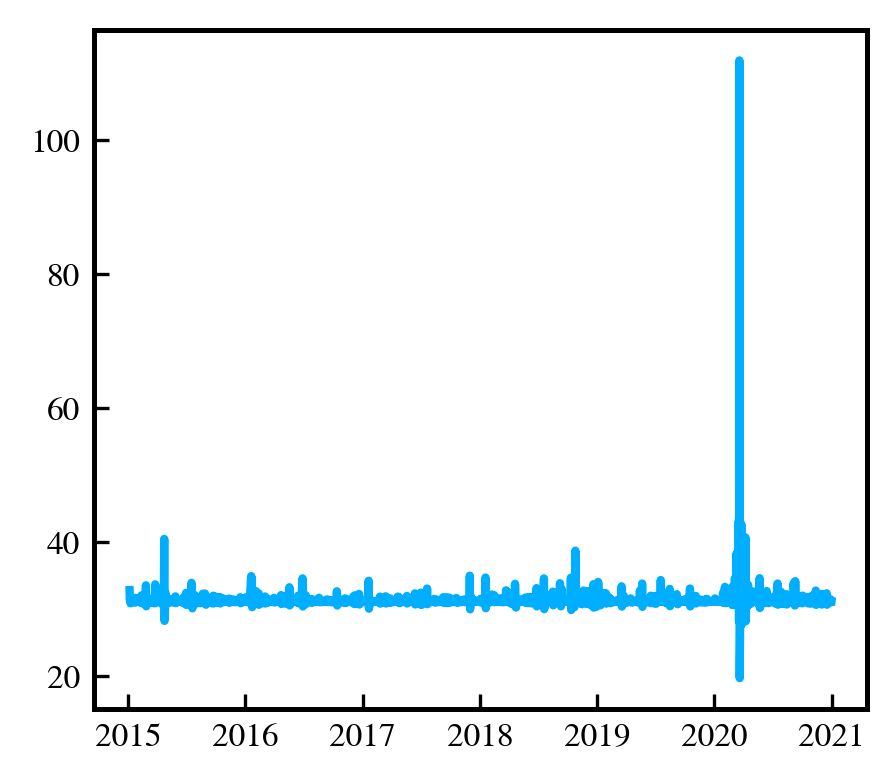

In [320]:
x,y=GED.plot_vola()
plt.plot(x,y)

In [9]:
closingreturns = daily_returns.values.flatten()*100

In [ ]:
plt.plot(t_tGAS[2:],tgas_vola[2:],lw=1, label='ETGAS')
plt.plot(t_GARCH[2:],tGARCH_vola[2:],lw=1, label='EGARCH')
#plt.plot(t_GARCH,GARCH.RVOL*np.sqrt(252),label='RVOL',lw=1)
plt.xlim([datetime.date(2020, 2, 1), datetime.date(2020, 12, 1)])
plt.plot(GARCH_time, GARCH_vola,label='GARCH(3,3)',lw=0.8,color='red')
plt.xticks(rotation=45)
plt.ylim(0,120)
plt.legend()

In [107]:
def get_qualities():
    df = pd.DataFrame({'Model':[],'p':[],'q':[],
                       'AIC':[],'BIC':[],'Log-Likelihood':[]})
    for p in np.arange(1,3,1,dtype=int):
        for q in np.arange(1,3,1,dtype=int):
            GARCH = estimate_GARCH(model='GARCH',p=p,q=q)
            AIC,BIC,L = GARCH.return_llik_AIC_BIC()
            df = df.append({'Model':'GARCH','p':p,'q':q,'AIC':AIC, 'BIC':BIC,'Log-Likelihood':L},ignore_index=True)
    for p in np.arange(1,3,1,dtype=int):
        for q in np.arange(1,3,1,dtype=int):
            GARCH = estimate_GARCH(model='RealGARCH',p=p,q=q)
            AIC,BIC,L = GARCH.return_llik_AIC_BIC()
            df = df.append({'Model':'RealGARCH','p':p,'q':q,'AIC':AIC, 'BIC':BIC,'Log-Likelihood':L},ignore_index=True)
    df = df.round(3)
    df['(p,q)'] = '('+df.p.astype(int).astype(str)+','+df.q.astype(int).astype(str)+')'
    df = df.set_index(['Model','(p,q)'])[['AIC','BIC','Log-Likelihood']]
    return df
quality_df = get_qualities()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.040873536779455
            Iterations: 22
            Function evaluations: 88
            Gradient evaluations: 22


KeyboardInterrupt: 

In [324]:
print(quality_df.to_latex())

\begin{tabular}{llrrr}
\toprule
          &       &     AIC &     BIC &  Log-Likelihood \\
Model & (p,q) &         &         &                 \\
\midrule
GARCH & (1,1) &  10.082 &  26.041 &          -2.041 \\
          & (1,2) &  12.082 &  33.361 &          -2.041 \\
          & (2,1) &  12.081 &  33.360 &          -2.040 \\
          & (2,2) &  14.081 &  40.680 &          -2.041 \\
RealGARCH & (1,1) &  10.019 &  25.978 &          -2.009 \\
          & (1,2) &  12.019 &  33.298 &          -2.009 \\
          & (2,1) &  12.018 &  33.297 &          -2.009 \\
          & (2,2) &  14.019 &  40.618 &          -2.009 \\
\bottomrule
\end{tabular}



In [ ]:
# Evaluate future predictions

In [115]:
def baseline_predict(x):
    """predict sigma_t for sigma_t+1 each time and evaluate the RMSE and MAE of it
       x is measures of realized volatility in the form of a dateframe"""
    # Get data for 2019 and 2020
    data_2019_2020 = pd.concat((x.loc['2019'],x.loc['2020']))
    # Predict latest value for each next sigma2
    data_2019_2020['predict_last'] = np.roll(data_2019_2020,1)
    # Or predict mean value for each sigma2
    data_2019_2020['predict_mean'] = np.mean(x.RealizedKernel)
    # Remove first since it is not relevant because of rolling
    data_2019_2020 = data_2019_2020.iloc[1:]
    # Obtain RMSE and MAE estimates
    RMSE_last = np.sqrt(np.mean((data_2019_2020.RealizedKernel-data_2019_2020.predict_last)**2))
    MAE_last  = np.mean(np.abs((data_2019_2020.RealizedKernel-data_2019_2020.predict_last)))
    RMSE_mean = np.sqrt(np.mean((data_2019_2020.RealizedKernel-data_2019_2020.predict_mean)**2))
    MAE_mean  = np.mean(np.abs((data_2019_2020.RealizedKernel-data_2019_2020.predict_mean)))

    return RMSE_last,MAE_last,RMSE_mean,MAE_mean
baseline_predict(np.sqrt(252*RK_values))

(6.244185408772254, 4.360478584809513, 11.963793459394658, 6.762887231197768)

In [335]:
def GARCH_predict(x):
    # Define GARCH model
    # Define GARCH model
    p,q = 1,1
    GARCH = estimate_GARCH('GARCH',p,q)
    # Load historical data to the GARCH model
    GARCH.closingreturns= pd.concat((daily_returns.loc['2015'],
                                 daily_returns.loc['2016'],
                                 daily_returns.loc['2017'],
                                 daily_returns.loc['2018'])).values.flatten()*100
    # Fit the GARCH model with 2015-2018 data
    GARCH.fit_garch(GARCH.closingreturns)
    # Obtain fit parameters
    thetahat = GARCH.thetahat
    
    
    GARCH_sigma = pd.DataFrame(index=GARCH.return_vola()[0])
    GARCH_sigma['sigma2'] = np.nan
    GARCH_sigma.loc[GARCH_sigma.index[:len(GARCH.return_vola()[1])]] = GARCH.return_vola()[1].reshape(len(GARCH.return_vola()[1]),1)
    GARCH_sigma.index = pd.Series(GARCH_sigma.index).apply(lambda x: x.strftime('%Y-%m-%d'))
    
    
    for t in np.where(GARCH_sigma.isna().values.flatten())[0]:
        alpha_part = 0
        beta_part  = 0
        for i in range(0,p):
            beta = thetahat[1+i+q]
            beta_part = beta_part+beta*GARCH_sigma[['sigma2']].iloc[t-i-1]
        for i in range(0,q):
            alpha = thetahat[1+i]
            alpha_part = alpha_part+alpha*(daily_returns.PRICE.iloc[t-i-1]*100)**2
        GARCH_sigma.iloc[t] = thetahat[0] + beta_part + alpha_part

    GARCH_sigma.index = pd.to_datetime(GARCH_sigma.index)
    GARCH_sigma.sigma2 = np.sqrt(252*GARCH_sigma.sigma2)
    GARCH_sigma = GARCH_sigma.join(np.sqrt(252*RK_values))
    ols_fit = OLS(GARCH_sigma.sigma2,GARCH_sigma.RealizedKernel)
    GARCH_sigma.sigma2 = GARCH_sigma.sigma2*ols_fit[0] + ols_fit[1]
    MAE  = np.mean(np.abs(GARCH_sigma['sigma2'] - GARCH_sigma['RealizedKernel']))
    RMSE = np.sqrt(np.nanmean((GARCH_sigma['sigma2'] - GARCH_sigma['RealizedKernel'])**2))

    
    return RMSE,MAE

GARCH_predict(RK_to_GARCH33)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.040873536779455
            Iterations: 22
            Function evaluations: 88
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.9835435315864576
            Iterations: 24
            Function evaluations: 97
            Gradient evaluations: 24


(7.254120796079388, 5.160476273628766)

In [314]:
GARCH.thetahat

array([0.55308007, 0.70949012, 0.12310389])